# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Project Goal

Based on the context above, this project will try to ask the questions below

- What factors mainly affect the usage of the offer from customer? Should the company send out the offer or not?
- How possible will a customer open and use the offer sent to them? Is there any common characteristics on the customers who take the offer?


# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [2]:
import pandas as pd
import numpy as np
import math
import json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from time import time
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor

% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Exploration
In order to analyze the problem better in next sections, first need to explore the datasets which includes checking the missing value, visualizing the data distribution, etc. In that way, we can have a better understanding on how the dataset looks like and how to select the important features to support the model implementation.

In [3]:
# view the portfolio dataset
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
# quick check on missing value in dataset
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

As shown above, there's no missing values in portfolio dataset.

In [5]:
# view the shape of dateset
portfolio.shape

(10, 6)

In [6]:
# the number of unique offer in dataset
portfolio.id.nunique()

10

In [7]:
# count the number of offer by offer type
portfolio.groupby('offer_type').id.count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

In [8]:
# view the profile dataset which contains demographic information
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


By viewing the first several rows of ther dataset, it parrently shows missing values in age column which is encoded as 118, and there are missing values in income column too.

In [9]:
# the number of user id
profile['id'].nunique()

17000

In [10]:
# quick check for null values in dataset
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [11]:
# number of missing values in age column
profile[profile.age==118].count()

age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64

In [12]:
# check if the rows which have missing age also have missing gender and income
profile[profile.age==118].head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


Apparently, the rows which have missing age also missing gender and income, which means probably it's fine to just drop the rows in the following steps to support the model implementation.

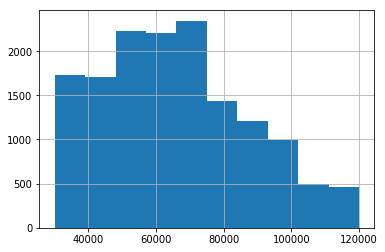

In [13]:
# get a quick view on income distribution
profile.income.hist()

In [14]:
# view the transcript dataset
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [15]:
# quick check on missing value
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [16]:
# quick chekc on the event distribution
transcript.groupby('event').person.count()

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: person, dtype: int64

In [17]:
# extract the different values in value column out
transcript = pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)
transcript.head()

,event,person,time,value,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [18]:
# clean up the duplicates in offer id and offer_id and meger into one column
transcript['clean_id'] = np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(), transcript['offer_id'],transcript['offer id'])

# drop the original id columns
transcript.drop(['offer id', 'offer_id'], axis=1, inplace=True)

# rename the offer_id column
transcript.rename(columns={'clean_id': 'offer_id'}, inplace=True)

In [19]:
# quick check on cleaned dataframe
transcript.head()

,event,person,time,value,amount,reward,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [20]:
# check if the number of type of offer consist with the portfolio dataset
transcript.offer_id.nunique()

10

# Data Preprocessing
In order to find out what mainly affect the finish of the transaction by sending the offer, in the data processing process, also need to process the data to merge the events of each specific offer sent so as to find out which offer were received, viewed and finally compeleted with a transaction.

In [21]:
# quick view on event distribution by offer_type by combining two dataset (portfolio, transcript)
transcript=transcript.merge(portfolio,how='left',left_on='offer_id',right_on='id')
transcript.groupby(['event','offer_type'])['offer_type'].count()

event            offer_type   
offer completed  bogo             15669
                 discount         17910
offer received   bogo             30499
                 discount         30543
                 informational    15235
offer viewed     bogo             25449
                 discount         21445
                 informational    10831
Name: offer_type, dtype: int64

Since offer_id is not associated with any 'transaction' event, in order to flag whether the offer has been finally completed with transaction, here need to link the offer id back to all transaction events. For BOGO and discount offer, both of them will have the consequence of offer received, viewed, transaction and offer completed which will apparently shows that the offer is redeemed and should definetly be sent out. For the information offer, though there's no reward step but there should still be transaction which is linked to the usage of offer.

In [22]:
# flag the customer who is really responsive to the offer
# (only when customer do the transaction after receiving and viewing the offer, it chould be counted as being 
# responsive to the offer, otherwise either 1) viewing the offer without any transaction or 2) make the transaction
# without receiving or viewing the offer shouldn't be counted as a response)

# drop the useless columns
transcript_processed = pd.DataFrame(transcript)

transcript_processed = transcript_processed.drop(columns=['reward_x','reward_y'], axis=1,inplace=False)
transcript_processed.head()

,event,person,time,value,amount,offer_id,channels,difficulty,duration,id,offer_type
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5.0,7.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,"[web, email]",20.0,10.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10.0,7.0,2906b810c7d4411798c6938adc9daaa5,discount
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10.0,10.0,fafdcd668e3743c1bb461111dcafc2a4,discount
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,"[web, email, mobile, social]",10.0,5.0,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo


In [23]:
# sort the events by person and time
transcript_processed = transcript_processed.sort_values(['person','time'])
transcript_processed.head(10)

,event,person,time,value,amount,offer_id,channels,difficulty,duration,id,offer_type
55972,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,5a8bc65990b245e5a138643cd4eb9837,informational
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,5a8bc65990b245e5a138643cd4eb9837,informational
89291,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,NaN,NaN,NaN,NaN,NaN,NaN
113605,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,3f207df678b143eea3cee63160fa8bed,informational
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,3f207df678b143eea3cee63160fa8bed,informational
153401,offer received,0009655768c64bdeb2e877511632db8f,408,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5.0,5.0,f19421c1d4aa40978ebb69ca19b0e20d,bogo
168412,transaction,0009655768c64bdeb2e877511632db8f,414,{'amount': 8.57},8.57,NaN,NaN,NaN,NaN,NaN,NaN
168413,offer completed,0009655768c64bdeb2e877511632db8f,414,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5.0,5.0,f19421c1d4aa40978ebb69ca19b0e20d,bogo
187554,offer viewed,0009655768c64bdeb2e877511632db8f,456,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5.0,5.0,f19421c1d4aa40978ebb69ca19b0e20d,bogo
204340,offer received,0009655768c64bdeb2e877511632db8f,504,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10.0,10.0,fafdcd668e3743c1bb461111dcafc2a4,discount


In [24]:
offer_completed = transcript_processed[['time','offer_id','person','event']][(transcript_processed['event']\
    =='transaction') | (transcript_processed['event']=='offer viewed')].groupby(['person','offer_id']).ffill()
offer_completed['offer_id'] = offer_completed['offer_id'].ffill()

In [25]:
# create the complete whole dataset for filtered data
transcript_processed = transcript_processed.merge(offer_completed, how='left', on=['person','time','event'])
transcript_processed.head()

,event,person,time,value,amount,offer_id_x,channels,difficulty,duration,id,offer_type,offer_id_y
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,5a8bc65990b245e5a138643cd4eb9837,informational,NaN
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,5a8bc65990b245e5a138643cd4eb9837,informational,5a8bc65990b245e5a138643cd4eb9837
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,NaN,NaN,NaN,NaN,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,3f207df678b143eea3cee63160fa8bed,informational,NaN
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,3f207df678b143eea3cee63160fa8bed,informational,3f207df678b143eea3cee63160fa8bed


In [26]:
# clean up the dataframe (removing the dummy columns)
transcript_processed['offer_id'] = np.where(transcript_processed['offer_id_x'].isnull(),\
                                            transcript_processed['offer_id_y'], transcript_processed['offer_id_x'])
transcript_processed.drop(columns=['offer_id_x','offer_id_y'], axis=1, inplace=True)

In [27]:
transcript_processed.head()

,event,person,time,value,amount,channels,difficulty,duration,id,offer_type,offer_id
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,"[email, mobile, social]",0.0,3.0,5a8bc65990b245e5a138643cd4eb9837,informational,5a8bc65990b245e5a138643cd4eb9837
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,"[email, mobile, social]",0.0,3.0,5a8bc65990b245e5a138643cd4eb9837,informational,5a8bc65990b245e5a138643cd4eb9837
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,NaN,NaN,NaN,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,"[web, email, mobile]",0.0,4.0,3f207df678b143eea3cee63160fa8bed,informational,3f207df678b143eea3cee63160fa8bed
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,"[web, email, mobile]",0.0,4.0,3f207df678b143eea3cee63160fa8bed,informational,3f207df678b143eea3cee63160fa8bed


In [28]:
transcript_processed = transcript_processed.merge(portfolio, how = 'left', left_on='offer_id', right_on='id')
transcript_processed['duration'] = np.where(transcript_processed['duration_x'].isnull(), \
                                            transcript_processed['duration_y'], transcript_processed['duration_x'])
transcript_processed.drop(columns=['duration_x','offer_type_x','difficulty_x','channels_x','duration_y'],\
                         axis=1, inplace=True)
transcript_processed.rename(columns={'channels_y':'channels','reward_y':'reward','difficulty_y':'difficulty','offer_type_y':'offer_type'},inplace=True)

In [29]:
# quick check on processed dataset
transcript_processed.head()

,event,person,time,value,amount,id_x,offer_id,channels,difficulty,id_y,offer_type,reward,duration
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,5a8bc65990b245e5a138643cd4eb9837,informational,0,3.0
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,5a8bc65990b245e5a138643cd4eb9837,informational,0,3.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,5a8bc65990b245e5a138643cd4eb9837,informational,0,3.0
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,3f207df678b143eea3cee63160fa8bed,informational,0,4.0
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,3f207df678b143eea3cee63160fa8bed,informational,0,4.0


Next, after we get the data together, we need to extract the transactions which were completed after the offer were received and viewed. Since we've already filled all transaction's offer id, we can extract the transactions converted from offers by checking if the offer id before the transaction is same as the transaction's offer id.

In [30]:
# subset the dataset with only offer viewed, transaction, and offer completed events
transactions_after_viewed = transcript_processed[(transcript_processed['event']=='offer viewed')|\
                                                 (transcript_processed['event']=='transaction')|\
                                                 (transcript_processed['event']=='offer completed')].copy()

# generate the previous offer id
transactions_after_viewed['pre_offer_id'] = transactions_after_viewed.groupby(['person', 'offer_id'])['offer_id'].shift()

# create flag for responsed offer which competed after customer viewing the offer
transactions_after_viewed['completed_offer'] = np.where(transactions_after_viewed['pre_offer_id']==\
                                                       transactions_after_viewed['offer_id'],1,0)

In [31]:
# quick view on dataset
transactions_after_viewed.head()

,event,person,time,value,amount,id_x,offer_id,channels,difficulty,id_y,offer_type,reward,duration,pre_offer_id,completed_offer
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,5a8bc65990b245e5a138643cd4eb9837,informational,0,3.0,NaN,0
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,5a8bc65990b245e5a138643cd4eb9837,informational,0,3.0,5a8bc65990b245e5a138643cd4eb9837,1
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,3f207df678b143eea3cee63160fa8bed,informational,0,4.0,NaN,0
6,transaction,0009655768c64bdeb2e877511632db8f,414,{'amount': 8.57},8.57,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,3f207df678b143eea3cee63160fa8bed,informational,0,4.0,3f207df678b143eea3cee63160fa8bed,1
7,offer completed,0009655768c64bdeb2e877511632db8f,414,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,NaN,f19421c1d4aa40978ebb69ca19b0e20d,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5.0,NaN,0


In [32]:
# join back the 'offer received' events which was filtered out in the previous step
offer_received = transcript_processed[transcript_processed['event']=='offer received']

offer_received['pre_offer_id']=np.nan
offer_received['completed_offer']=np.nan

transcript_processed = offer_received.append(transactions_after_viewed).sort_values(['person','time'])
transcript_processed.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,event,person,time,value,amount,id_x,offer_id,channels,difficulty,id_y,offer_type,reward,duration,pre_offer_id,completed_offer
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,5a8bc65990b245e5a138643cd4eb9837,informational,0,3.0,NaN,NaN
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,5a8bc65990b245e5a138643cd4eb9837,informational,0,3.0,NaN,0.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,5a8bc65990b245e5a138643cd4eb9837,informational,0,3.0,5a8bc65990b245e5a138643cd4eb9837,1.0
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,3f207df678b143eea3cee63160fa8bed,informational,0,4.0,NaN,NaN
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,3f207df678b143eea3cee63160fa8bed,informational,0,4.0,NaN,0.0


Since different offer has difference consequece of compeletion, for example, for informational offer, there'll not be rewards. Therefore, seperate the transcript data by offer type for easier analysis.

In [33]:
#split transcript into 3 different offer types
bogo = transcript_processed[transcript_processed['offer_type']=='bogo'].copy()
discount = transcript_processed[transcript_processed['offer_type']=='discount'].copy()
informational = transcript_processed[transcript_processed['offer_type']=='informational'].copy()


In [34]:
# quick view on seperated data
bogo.head()

,event,person,time,value,amount,id_x,offer_id,channels,difficulty,id_y,offer_type,reward,duration,pre_offer_id,completed_offer
5,offer received,0009655768c64bdeb2e877511632db8f,408,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},NaN,f19421c1d4aa40978ebb69ca19b0e20d,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5.0,NaN,NaN
7,offer completed,0009655768c64bdeb2e877511632db8f,414,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,NaN,f19421c1d4aa40978ebb69ca19b0e20d,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5.0,NaN,0.0
8,offer viewed,0009655768c64bdeb2e877511632db8f,456,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},NaN,f19421c1d4aa40978ebb69ca19b0e20d,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5.0,f19421c1d4aa40978ebb69ca19b0e20d,1.0
10,transaction,0009655768c64bdeb2e877511632db8f,528,{'amount': 14.11},14.11,NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5.0,f19421c1d4aa40978ebb69ca19b0e20d,1.0
20,offer received,00116118485d4dfda04fdbaba9a87b5c,168,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},NaN,f19421c1d4aa40978ebb69ca19b0e20d,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5.0,NaN,NaN


In [35]:
discount.head()

,event,person,time,value,amount,id_x,offer_id,channels,difficulty,id_y,offer_type,reward,duration,pre_offer_id,completed_offer
9,offer received,0009655768c64bdeb2e877511632db8f,504,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,fafdcd668e3743c1bb461111dcafc2a4,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,10.0,NaN,NaN
11,offer completed,0009655768c64bdeb2e877511632db8f,528,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,NaN,fafdcd668e3743c1bb461111dcafc2a4,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,10.0,NaN,0.0
12,offer viewed,0009655768c64bdeb2e877511632db8f,540,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,fafdcd668e3743c1bb461111dcafc2a4,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,10.0,fafdcd668e3743c1bb461111dcafc2a4,1.0
13,transaction,0009655768c64bdeb2e877511632db8f,552,{'amount': 13.56},13.56,NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,10.0,fafdcd668e3743c1bb461111dcafc2a4,1.0
14,offer received,0009655768c64bdeb2e877511632db8f,576,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,2906b810c7d4411798c6938adc9daaa5,2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10,2906b810c7d4411798c6938adc9daaa5,discount,2,7.0,NaN,NaN


In [36]:
informational.head()

,event,person,time,value,amount,id_x,offer_id,channels,difficulty,id_y,offer_type,reward,duration,pre_offer_id,completed_offer
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,5a8bc65990b245e5a138643cd4eb9837,informational,0,3.0,NaN,NaN
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,5a8bc65990b245e5a138643cd4eb9837,informational,0,3.0,NaN,0.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,5a8bc65990b245e5a138643cd4eb9837,informational,0,3.0,5a8bc65990b245e5a138643cd4eb9837,1.0
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,3f207df678b143eea3cee63160fa8bed,informational,0,4.0,NaN,NaN
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,3f207df678b143eea3cee63160fa8bed,informational,0,4.0,NaN,0.0


Within each offer type, use responded_offer flagged in previous steps we can filter out the offers which were seccussfully viewed, and completed by users. For bogo and discount offer, the reponsed offer should be the one that with 'offer complete' events, and for informational offer, just 'transaction' can be seen as a successful offer.

In [37]:
# extract responded offer under bogo and informational type
bogo_completed = bogo[['person','offer_id']][(bogo['completed_offer']==1) & (bogo['event']=='offer completed')].groupby(['person','offer_id']).count().reset_index()
discount_completed = discount[['person','offer_id']][(discount['completed_offer']==1) & (discount['event']=='offer completed')].groupby(['person','offer_id']).count().reset_index()

Next, will seperate out customers who only viewed the offers without transaction and completion in the end, and the customers who only received the offer without viewing it.

In [38]:
# filter out offer with transactions or completed, and offer which have viewed events
bogo_ids_transaction_completed = bogo[['person','offer_id']][(bogo['event']=='transaction') | \
                            (bogo['event']=='offer completed') ].groupby(['person','offer_id']).count().reset_index()
bogo_ids_received = bogo[['person','offer_id']][bogo['event']=='offer received'].groupby(['person','offer_id']).count().reset_index()

# get the offer records which was only viewed without transaction and completion
bogo_merged = bogo_ids_transaction_completed.merge(bogo_ids_received,how='right',on=['person','offer_id'],indicator=True)
bogo_merged.head()

,person,offer_id,_merge
0,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,both
1,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,both
2,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,both
3,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,both
4,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,both


In [39]:
# do the same processing on discountrmational offer
discount_ids_transaction_completed = discount[['person','offer_id']][(discount['event']=='transaction') | \
                            (discount['event']=='offer completed') ].groupby(['person','offer_id']).count().reset_index()
discount_ids_received = discount[['person','offer_id']][discount['event']=='offer received'].groupby(['person','offer_id']).count().reset_index()

# get the offer records which was only viewed without transaction and completion
discount_merged = discount_ids_transaction_completed.merge(discount_ids_received,how='right',on=['person','offer_id'],indicator=True)
discount_merged.head()

,person,offer_id,_merge
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,both
1,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,both
2,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,both
3,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,both
4,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,both


Then, based on merged dataset above, we can seperate out customers who only viewed the offer after they received the offer and customers who didn't even open the offer after they receive the offer.

In [40]:
# subtract the customers who received the offer without finishing the transaction
bogo_no_transaction = bogo_merged[bogo_merged['_merge']=='right_only']
bogo_no_transaction = bogo_no_transaction.merge(transcript_processed, how='left',on=['person','offer_id'])

# subset users who only veiwed the offer and people who viewed the offer but didn't make transaction
bogo_viewed = bogo_no_transaction[['person','offer_id']][bogo_no_transaction['event']=='offer viewed']\
                .groupby(['person','offer_id']).count().reset_index()
bogo_no_transaction.drop(['_merge'], axis=1, inplace=True)

# get the customers who didn't even view the offer after they received the BOGO offer 
bogo_no_view = bogo_no_transaction.merge(bogo_viewed[['person','offer_id']], how='left', indicator=True)
bogo_no_view = bogo_no_view[bogo_no_view['_merge']=='left_only'].copy()


In [41]:
# do the same action on discountrmational offer

# subtract the customers who received the offer without finishing the transaction
discount_no_transaction = discount_merged[discount_merged['_merge']=='right_only']
discount_no_transaction = discount_no_transaction.merge(transcript_processed, how='left',on=['person','offer_id'])

# subset users who only veiwed the offer and people who viewed the offer but didn't make transaction
discount_viewed = discount_no_transaction[['person','offer_id']][discount_no_transaction['event']=='offer viewed']\
                .groupby(['person','offer_id']).count().reset_index()
discount_no_transaction.drop(['_merge'], axis=1, inplace=True)

# get the customers who didn't even view the offer after they received the discount offer 
discount_no_view = discount_no_transaction.merge(discount_viewed[['person','offer_id']], how='left', indicator=True)
discount_no_view = discount_no_view[discount_no_view['_merge']=='left_only'].copy()


After above processing, filter out the transaction regardless of receiving or viewing the offer.

In [42]:
# subset the offer which has no correction with offer
bogo_unrelated = bogo[['person','offer_id']][(bogo['event']=='offer completed') & (bogo['completed_offer']!=1)]\
                    .groupby(['person','offer_id']).count().reset_index()
discount_unrelated = discount[['person','offer_id']][(discount['event']=='offer completed')\
                    & (discount['completed_offer']!=1)].groupby(['person','offer_id']).count().reset_index()

After seperating the different cases of customers, in the following steps will firstly focus on customers who finish the transaction after receive the offer and customer who only view the offer without any transaction.

In [43]:
# combine the two kind of customers cases which are focused on
bogo_completed['offer_responded']=1
bogo_viewed['offer_responded']=0
bogo_offer = bogo_completed.append(bogo_viewed, sort=False)

discount_completed['offer_responded']=1
discount_viewed['offer_responded']=0
discount_offer = discount_completed.append(discount_viewed, sort=False)


Ast for the informational offer, the offer could only be counted as responded under the affect of the offer when the transaction is finished within the duration of the offer.

In [44]:
#convert time into days
informational['day_offer']=informational['time']/24
#drop unnecessary columns
informational.drop(['time','value','pre_offer_id'], axis=1, inplace=True)
informational=informational.sort_values(['person','day_offer','event','offer_id'])

#get difference in time for informational offers
informational['diff']=informational[(informational['offer_type']=='informational') \
                                         & ((informational['event']=='offer received')\
                                            | (informational['event']=='transaction'))].groupby(['person','offer_id'])['day_offer'].diff()
informational['valid_completion']=np.nan
#flag valid events if within duration
informational.loc[informational['diff']<=informational['duration'],'valid_completion']=1
#fill any missing values with 0 flag
informational['valid_completion']=informational['valid_completion'].fillna(value=0)

In [45]:
# quick check on dataset
informational.head()

,event,person,amount,id_x,offer_id,channels,difficulty,id_y,offer_type,reward,duration,completed_offer,day_offer,diff,valid_completion
0,offer received,0009655768c64bdeb2e877511632db8f,NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,5a8bc65990b245e5a138643cd4eb9837,informational,0,3.0,NaN,7.0,NaN,0.0
1,offer viewed,0009655768c64bdeb2e877511632db8f,NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,5a8bc65990b245e5a138643cd4eb9837,informational,0,3.0,0.0,8.0,NaN,0.0
2,transaction,0009655768c64bdeb2e877511632db8f,22.16,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,5a8bc65990b245e5a138643cd4eb9837,informational,0,3.0,1.0,9.5,2.5,1.0
3,offer received,0009655768c64bdeb2e877511632db8f,NaN,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,3f207df678b143eea3cee63160fa8bed,informational,0,4.0,NaN,14.0,NaN,0.0
4,offer viewed,0009655768c64bdeb2e877511632db8f,NaN,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,3f207df678b143eea3cee63160fa8bed,informational,0,4.0,0.0,15.5,NaN,0.0


As shown above, only when customer make the transaction during the offer effective duration, it can be counted as successfully responsed offer.

In [46]:
#flag successfully responded offer where completed_offer=1 and valid_completion=1
informational['offer_responded']=np.where(((informational['completed_offer']==1)\
                                           & (informational['valid_completion']==1)),1,0)

In [47]:
# extract the informational offer successfully compelted after
info_completed = informational[['person','offer_id']][informational['offer_responded']==1]\
                        .groupby(['person','offer_id']).sum().reset_index()

In [48]:
# filter out offer with transactions or completed, and offer which have viewed events
informational_ids_transaction_completed = informational[['person','offer_id']][(informational['event']=='transaction') | \
                            (informational['event']=='offer completed') ].groupby(['person','offer_id']).count().reset_index()
informational_ids_received = informational[['person','offer_id']][informational['event']=='offer received'].groupby(['person','offer_id']).count().reset_index()

# get the offer records which was only viewed without transaction and completion
informational_merged = informational_ids_transaction_completed.merge(informational_ids_received,how='right',on=['person','offer_id'],indicator=True)
informational_merged.head()

,person,offer_id,_merge
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,both
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,both
2,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,both
3,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,both
4,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,both


In [49]:
# subtract the customers who received the offer without finishing the transaction
informational_no_transaction = informational_merged[informational_merged['_merge']=='right_only']
informational_no_transaction = informational_no_transaction.merge(transcript_processed, how='left',on=['person','offer_id'])

# subset users who only veiwed the offer and people who viewed the offer but didn't make transaction
informational_viewed = informational_no_transaction[['person','offer_id']][informational_no_transaction['event']=='offer viewed']\
                .groupby(['person','offer_id']).count().reset_index()
informational_no_transaction.drop(['_merge'], axis=1, inplace=True)

# get the customers who didn't even view the offer after they received the informational offer 
informational_no_view = informational_no_transaction.merge(informational_viewed[['person','offer_id']], how='left', indicator=True)
informational_no_view = informational_no_view[informational_no_view['_merge']=='left_only'].copy()


In [50]:
# append the informational offer together
info_completed['offer_responded']=1
informational_viewed['offer_responded']=0
informational_offer = info_completed.append(informational_viewed, sort=False)


## Feature engineering

After basic processing, next step will look if there's any columns which can be used to create new features.

- generate a new column for length of customer's membership

In [51]:
profile.rename(columns={'id':'person'},inplace=True)

#create function to generate the length of time since the user become the member
def member_since(df):
    '''
    inputs:
    - df: dataframe to generate the ength of time since the user become the member
    outputs:
    - Returns dataframe with became_member_on column transformed to be tenure in days
    
    '''
    #merge to get user demographic profile
    df=df.merge(profile,how='left',on='person')
    
    df['year']=pd.Series([int(str(x)[:4]) for x in df['became_member_on']])
    df['month']=pd.Series([int(str(x)[-3]) for x in df['became_member_on']])
    df['day']=pd.Series([int(str(x)[-2:]) for x in df['became_member_on']])
    df = df.drop('became_member_on', axis=1, inplace=False)
    df.loc[df['year'] == 2018, 'membership_days'] = (30*df['month'])+df['day']
    df.loc[df['year'] != 2018, 'membership_days'] = ((2018-df['year'])*365)+(30*df['month'])+df['day']
    df = df.drop(['year','month','day'], axis=1, inplace=False)
    
    return df

bogo_offer=member_since(bogo_offer)
discount_offer=member_since(discount_offer)
informational_offer=member_since(informational_offer)

In [52]:
bogo_offer.head()

,person,offer_id,offer_responded,age,gender,income,membership_days
0,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,40,O,57000.0,39.0
1,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1,59,F,90000.0,824.0
2,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,24,F,60000.0,771.0
3,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,1,24,F,60000.0,771.0
4,004b041fbfe44859945daa2c7f79ee64,f19421c1d4aa40978ebb69ca19b0e20d,1,55,F,74000.0,158.0


- generate the count of offer received for each user

In [53]:
transcript.head()

,event,person,time,value,amount,reward_x,offer_id,channels,difficulty,duration,id,offer_type,reward_y
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5.0,7.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,"[web, email]",20.0,10.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,NaN,2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10.0,7.0,2906b810c7d4411798c6938adc9daaa5,discount,2.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10.0,10.0,fafdcd668e3743c1bb461111dcafc2a4,discount,2.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,"[web, email, mobile, social]",10.0,5.0,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10.0


In [54]:
# generate the count of offers received per person
offer_cnt=transcript_processed[transcript_processed['event']=='offer received'].groupby(['person','offer_id','time']).count()['event'].reset_index()
offer_cnt.rename(columns={'event':'offer_received_cnt'},inplace=True)

offer_cnt.drop(['time'], axis=1, inplace=True)

# ensure only unique person-offer_id pairs
offer_cnt=offer_cnt.groupby(['person','offer_id']).sum().reset_index()
offer_cnt.head()

,person,offer_id,offer_received_cnt
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1


- subtract the transactions which's not related to the offer

In [55]:
# subtract the transactions which's not related to the offer
transactions_not_related=transcript_processed[(transcript_processed['event']=='transaction') & (transcript_processed['completed_offer']==0)].groupby(['person','offer_id'])['amount'].sum().reset_index()
transactions_not_related.rename(columns={'amount':'amount_invalid'},inplace=True)

- calculate the time lap between offers

In [56]:
# convert time into days
transcript_processed['day_offer']=transcript_processed['time']/24
# drop unnecessary columns
transcript_processed.drop(['time'], axis=1, inplace=True)

# calculate the time between offers
transcript_processed['time_gap']=transcript_processed[transcript_processed['event']=='offer received'].groupby(['person','offer_id'])['day_offer'].diff()

# fill missing values with 0
transcript_processed['time_gap']=transcript_processed['time_gap'].fillna(value=0)

df_time_gap=transcript_processed.groupby(['person','offer_id'])['time_gap'].sum().reset_index()

- Merge the temporary data created above together, then drop the missing values in gender column, and split the channel column to the categorical variable

In [57]:
# merge to get offers received count and invalid amount transacted 
bogo_offer=bogo_offer.merge(offer_cnt[['person','offer_id','offer_received_cnt']],how='left',on=['person','offer_id'])
bogo_offer=bogo_offer.merge(transactions_not_related[['person','offer_id','amount_invalid']],how='left',on=['person','offer_id'])

In [58]:
# fill missing values for amount_invalid with 0
bogo_offer['amount_invalid']=bogo_offer['amount_invalid'].fillna(value=0)
bogo_offer.dropna(inplace=True)

In [59]:
bogo_offer.head()

,person,offer_id,offer_responded,age,gender,income,membership_days,offer_received_cnt,amount_invalid
0,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,40,O,57000.0,39.0,1,0.0
1,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1,59,F,90000.0,824.0,1,0.0
2,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,24,F,60000.0,771.0,1,0.0
3,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,1,24,F,60000.0,771.0,1,0.0
4,004b041fbfe44859945daa2c7f79ee64,f19421c1d4aa40978ebb69ca19b0e20d,1,55,F,74000.0,158.0,1,0.0


In [60]:
# Split the channel column into categorical variables
def rename(col_name,df):
    df[col_name]=np.where(df[col_name]==col_name,1,0)
    return df

# dummy variable encoding function
def dummy(df,col):
    df = pd.concat([df[:],pd.get_dummies(df[col],prefix=col)],axis=1)
    df = df.drop([col], axis=1, inplace=False)
    return df

portfolio.rename(columns={'id':'offer_id'}, inplace=True)

In [61]:
# merge with portfolio to get offer details
bogo_offer=bogo_offer.merge(portfolio,how='left',on='offer_id')

# convert channels into categorical variables
channels = bogo_offer['channels'].apply(pd.Series)
channels = channels.rename(columns={0:'web',1:'email',2:'mobile',3:'social'})
bogo_offer = pd.concat([bogo_offer[:], channels[:]], axis=1)
rename('web',bogo_offer)
rename('email',bogo_offer)
rename('mobile',bogo_offer)
rename('social',bogo_offer)
bogo_offer = bogo_offer.drop(['channels'], axis=1, inplace=False)

# convert gender into categorical variables
bogo_offer=dummy(bogo_offer,'gender')

In [62]:
# quick check on processed data
bogo_offer.head()

,person,offer_id,offer_responded,age,income,membership_days,offer_received_cnt,amount_invalid,difficulty,duration,offer_type,reward,web,email,mobile,social,gender_F,gender_M,gender_O
0,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,40,57000.0,39.0,1,0.0,5,7,bogo,5,1,1,1,0,0,0,1
1,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1,59,90000.0,824.0,1,0.0,10,5,bogo,10,1,1,1,1,1,0,0
2,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,24,60000.0,771.0,1,0.0,5,7,bogo,5,1,1,1,0,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,1,24,60000.0,771.0,1,0.0,5,5,bogo,5,1,1,1,1,1,0,0
4,004b041fbfe44859945daa2c7f79ee64,f19421c1d4aa40978ebb69ca19b0e20d,1,55,74000.0,158.0,1,0.0,5,5,bogo,5,1,1,1,1,1,0,0


In [63]:
# quick view on discount_offer data
discount_offer.head()

,person,offer_id,offer_responded,age,gender,income,membership_days
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,40,O,57000.0,39.0
1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,40,O,57000.0,39.0
2,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,1,59,F,90000.0,824.0
3,0020ccbbb6d84e358d3414a3ff76cffd,2298d6c36e964ae4a3e7e9706d1fb8c2,1,24,F,60000.0,771.0
4,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4,1,26,F,73000.0,566.0


In [64]:
# do the same processing on discount data
# merge to get offers received count and invalid amount transacted 
discount_offer = discount_offer.merge(offer_cnt[['person','offer_id','offer_received_cnt']],how='left',on=['person','offer_id'])
discount_offer = discount_offer.merge(transactions_not_related[['person','offer_id','amount_invalid']],how='left',on=['person','offer_id'])

In [65]:
# fill missing values for amount_invalid with 0
discount_offer['amount_invalid']=discount_offer['amount_invalid'].fillna(value=0)
discount_offer.dropna(inplace=True)

In [66]:
# merge with portfolio to get offer details
discount_offer= discount_offer.merge(portfolio,how='left',on='offer_id')

# convert channels into categorical variables
channels = discount_offer['channels'].apply(pd.Series)
channels = channels.rename(columns={0:'web',1:'email',2:'mobile',3:'social'})
discount_offer = pd.concat([discount_offer[:], channels[:]], axis=1)
rename('web',discount_offer)
rename('email',discount_offer)
rename('mobile',discount_offer)
rename('social',discount_offer)
discount_offer = discount_offer.drop(['channels'], axis=1, inplace=False)

#convert gender into categorical variables
discount_offer=dummy(discount_offer,'gender')

In [67]:
# quick view on discount_offer data
discount_offer.head()

,person,offer_id,offer_responded,age,income,membership_days,offer_received_cnt,amount_invalid,difficulty,duration,offer_type,reward,web,email,mobile,social,gender_F,gender_M,gender_O
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,40,57000.0,39.0,1,0.0,20,10,discount,5,1,1,0,0,0,0,1
1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,40,57000.0,39.0,1,0.0,7,7,discount,3,1,1,1,1,0,0,1
2,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,1,59,90000.0,824.0,2,0.0,10,10,discount,2,1,1,1,1,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,2298d6c36e964ae4a3e7e9706d1fb8c2,1,24,60000.0,771.0,1,0.0,7,7,discount,3,1,1,1,1,1,0,0
4,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4,1,26,73000.0,566.0,2,0.0,10,10,discount,2,1,1,1,1,1,0,0


In [68]:
# quick view on informational_offer data
informational_offer.head()

,person,offer_id,offer_responded,age,gender,income,membership_days
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,33,M,72000.0,506.0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,33,M,72000.0,506.0
2,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,1,59,F,90000.0,824.0
3,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,1,24,F,60000.0,771.0
4,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,1,26,F,73000.0,566.0


In [69]:
# processing on informational data
# merge with portfolio to get offer details
informational_offer = informational_offer.merge(portfolio,how='left',on='offer_id')

# reset index for informational_offer
informational_offer = informational_offer.reset_index().drop(['index'],axis=1,inplace=False)

# split the channel column
informational_offer['email']= np.nan
informational_offer.loc[pd.Series(['email' in informational_offer['channels'][x] for x in range(len(informational_offer['channels']))]),'email']=1
informational_offer['email']=informational_offer['email'].fillna(value=0)

informational_offer['mobile']= np.nan
informational_offer.loc[pd.Series(['mobile' in informational_offer['channels'][x] for x in range(len(informational_offer['channels']))]),'mobile']=1
informational_offer['mobile']=informational_offer['mobile'].fillna(value=0)

informational_offer['social']= np.nan
informational_offer.loc[pd.Series(['social' in informational_offer['channels'][x] for x in range(len(informational_offer['channels']))]),'social']=1
informational_offer['social']=informational_offer['social'].fillna(value=0)

# drop the useless columns
informational_offer.drop(['channels'], axis=1, inplace=True)

In [70]:
# merge the informational offer dataframe
informational_offer = informational_offer.merge(offer_cnt[['person','offer_id','offer_received_cnt']],how='left',on=['person','offer_id'])
informational_offer = informational_offer.merge(transactions_not_related[['person','offer_id','amount_invalid']],how='left',on=['person','offer_id'])


In [71]:
# fill missing values for amount_invalid and offer_received_cnt with 0
informational_offer['amount_invalid']=informational_offer['amount_invalid'].fillna(value=0)

#drop income and gender null rows
informational_offer.dropna(inplace=True);    

#convert gender column into dummy variables
informational_offer=dummy(informational_offer,'gender')

In [72]:
# quick view on informational_offer data
informational_offer.head()

,person,offer_id,offer_responded,age,income,membership_days,difficulty,duration,offer_type,reward,email,mobile,social,offer_received_cnt,amount_invalid,gender_F,gender_M,gender_O
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,33,72000.0,506.0,0,4,informational,0,1.0,1.0,0.0,1.0,0.00,0,1,0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,33,72000.0,506.0,0,3,informational,0,1.0,1.0,1.0,1.0,0.00,0,1,0
2,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,1,59,90000.0,824.0,0,3,informational,0,1.0,1.0,1.0,1.0,0.00,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,1,24,60000.0,771.0,0,3,informational,0,1.0,1.0,1.0,1.0,16.27,1,0,0
4,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,1,26,73000.0,566.0,0,4,informational,0,1.0,1.0,0.0,1.0,0.00,1,0,0


## Building model
After preprossesing the data, next step we'll start to impletment models to figure out which factors affect most whether the customer will respond the offer or not. And this project also attempt to predict whether the customer will respond tthe different type of offers or not.

Therefore, we'll use 'offer_responded' flag in the dataset to build modles to predict if the customer will respond to the offer of not. Here will choose basic tree model as a baseline which will help explain the feature importance better so that we can get some insight on what factors affect customer's behavior most.

### Model implementation preparation
- Prepare the dateset, set the features variable and target columns

In [73]:
def data_prep(df,drop_cols_prep):
    '''
    inputs:
    - df: prepared dataframe for modeling 
    
    outputs:
    - Returns 2 dataframes - features and target dataframes
    '''
    # Split the data into features and target label
    target = df['offer_responded']
    features = df.drop(drop_cols_prep, axis=1, inplace=False)
    return features,target

- Split the data into training and test sets

In [74]:
def model_pipeline(features,target):
    '''
    inputs:
    - features & target dataframe 
    
    outputs:
    - Splits features and target dataframe to train and test sets, performs feature scaling on both datasets.
    - Outputs X_train, X_test, y_train and y_test dataframes
    '''
    
    #split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features,target, test_size=0.20, random_state=42)

    #fit and transform scaling on training data
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)

    #scale test data
    X_test=scaler.transform(X_test)
    return X_train,X_test,y_train, y_test

- Create function to execute the model for different offer types

In [75]:
# reference: Udacity -- 'Finding Donors for Charity ML' project
# reference: Udacity -- 'Creating Customer Segments with Arvato' project
def train_predict(model, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - model: the model to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: review_scores_rating training set
       - X_test: features testing set
       - y_test: review_scores_rating testing set
    '''
    results = {}
    
    #Fit the model to the training data and get training time
    start = time() 
    model = model.fit(X_train, y_train)
    end = time() 
    results['train_time'] = end-start
    
    # Get predictions on the test set(X_test), then get predictions on first 300 training samples
    start = time() 
    predictions_test = model.predict(X_test)
    predictions_train = model.predict(X_train)
    end = time() 
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
    
    #add training accuracy to results
    results['training_score']=model.score(X_train,y_train)
    
    #add testing accuracy to results
    results['testing_score']=model.score(X_test,y_test)
     
    print("{} trained on {} samples.".format(model.__class__.__name__, len(y_train)))
    print("MSE_train: %.4f" % mean_squared_error(y_train,predictions_train))
    print("MSE_test: %.4f" % mean_squared_error(y_test,predictions_test))
    print("Training accuracy:%.4f" % results['training_score'])
    print("Test accuracy:%.4f" % results['testing_score'])
    print(classification_report(y_test, predictions_test,digits=4))
    return results

In [76]:
def run_model(clf1,clf2,name):
    '''
    inputs:
    - clf1: first classifier model
    - clf2: 2nd classifier model for comparison
    - name: name of models for comparison
    
    outputs:
    - Dataframe of results from model training and prediction
    '''
    
    # Collect results from models
    results = {}
    for clf in [clf1, clf2]:
        clf_name = clf.__class__.__name__ + '_' +name
        results[clf_name] = {}
        results[clf_name]= train_predict(clf, X_train, y_train, X_test, y_test)
    return pd.DataFrame(results)

### Initial the model baseline
At this point, will firstly use default parameters for baseline model and will tune the parameters in the later tuning steps if needed.

- __BOGO model__

In [77]:
# implement the model for BOGO offer
drop_cols_prep=['person','offer_id','offer_responded','offer_type']
features,target=data_prep(bogo_offer,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

# initialize the model - baseline is DT model, bogo_1 model is RF model
baseline = DecisionTreeClassifier(criterion='entropy',max_depth=5,random_state=2,min_samples_split=90,min_samples_leaf=50)
bogo_1 = RandomForestClassifier(random_state=2,max_depth= 11, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=20)

results=run_model(baseline,bogo_1,'bogo_1')

DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.1770
MSE_test: 0.1823
Training accuracy:0.8230
Test accuracy:0.8177
             precision    recall  f1-score   support

          0     0.4797    0.2694    0.3450       438
          1     0.8553    0.9366    0.8941      2020

avg / total     0.7884    0.8177    0.7963      2458

RandomForestClassifier trained on 9829 samples.
MSE_train: 0.1670
MSE_test: 0.1786
Training accuracy:0.8330
Test accuracy:0.8214
             precision    recall  f1-score   support

          0     0.4906    0.0594    0.1059       438
          1     0.8287    0.9866    0.9008      2020

avg / total     0.7684    0.8214    0.7591      2458



As shown above, the accuracy of both model are good for initial model inplementation. But the F1 score is a bit lower than 80% which may be tuned better in the later steps. Although Decision Tree's F1 performs a little better than Random Forest, there's not big hurt to send out some more offers to people who's not gonna respond in the end. Therefore, here can still select the random forest with slightly better accuracy right now.

- __Discount Offer model__

In [78]:
# instantiate the model for discount offer
drop_cols_prep=['person','offer_id','offer_responded','offer_type']
features,target=data_prep(discount_offer,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
discount_1 = RandomForestClassifier(random_state=2,max_depth= 20, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=10)
results=pd.concat([results[:],run_model(baseline,discount_1,'discount_1')],axis=1)

DecisionTreeClassifier trained on 10179 samples.
MSE_train: 0.1371
MSE_test: 0.1277
Training accuracy:0.8629
Test accuracy:0.8723
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       325
          1     0.8723    1.0000    0.9318      2220

avg / total     0.7609    0.8723    0.8128      2545



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 10179 samples.
MSE_train: 0.1313
MSE_test: 0.1277
Training accuracy:0.8687
Test accuracy:0.8723
             precision    recall  f1-score   support

          0     0.5000    0.0062    0.0122       325
          1     0.8729    0.9991    0.9317      2220

avg / total     0.8253    0.8723    0.8143      2545



As shown above, the random forest performs slightly better than random forest.

- __Informational offer model__

In [80]:
# implement model for informational offer
features,target=data_prep(informational_offer,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
info_1 = RandomForestClassifier(random_state=5,criterion='gini',max_depth= 20, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=10)
results=pd.concat([results[:],run_model(baseline,info_1,'info_1')],axis=1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.2462
MSE_test: 0.2541
Training accuracy:0.7538
Test accuracy:0.7459
             precision    recall  f1-score   support

          0     0.5000    0.1127    0.1839       355
          1     0.7608    0.9616    0.8495      1042

avg / total     0.6945    0.7459    0.6804      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.2319
MSE_test: 0.2520
Training accuracy:0.7681
Test accuracy:0.7480
             precision    recall  f1-score   support

          0     0.5200    0.1099    0.1814       355
          1     0.7610    0.9655    0.8511      1042

avg / total     0.6997    0.7480    0.6809      1397



### Model tuning
This section will attempt to tune the parameters of initial model to get higher performance.

In [81]:
# create the function to find best model results for each offer type
def best_model(offer_type):
    '''
    input:
    - offer_type: string of offer type name
    output:
    - dataframe containing results of best model so far
    
    '''
    print(offer_type + ' RF model:')
    return results.transpose()[results.transpose()['testing_score']==results.transpose()[results.transpose().index.str.contains("RandomForestClassifier_"+offer_type)]['testing_score'].max()]

In tuning section, will first use GridSearch to search for parameters which is likely to get better model performance.

In [82]:
#define Grid Search function
def rand_forest_param_selection(X,y):
    '''
    input:
    - X,y: training datasets for X and y
    output:
    - dictionary with best parameters for random forest model
    '''
    
    param_grid={'max_features': ['auto', 'sqrt'],
                'max_depth' : [10,15],
                'n_estimators': [10,20,25,30],
                'min_samples_split': [10, 20],
                'min_samples_leaf': [10,15],
                }
    grid_search = GridSearchCV(RandomForestClassifier(random_state=2), param_grid)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [84]:
#define BOGO dataset
features,target=data_prep(bogo_offer,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#run Grid Search
rand_forest_param_selection(X_train, y_train)

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 20}

In [86]:
# use optimized parameters to rerun the model in previous step
# initialize the model
bogo_2 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=10)

results=pd.concat([results[:],run_model(baseline,bogo_2,'bogo_2')],axis=1)

DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.1770
MSE_test: 0.1823
Training accuracy:0.8230
Test accuracy:0.8177
             precision    recall  f1-score   support

          0     0.4797    0.2694    0.3450       438
          1     0.8553    0.9366    0.8941      2020

avg / total     0.7884    0.8177    0.7963      2458

RandomForestClassifier trained on 9829 samples.
MSE_train: 0.1613
MSE_test: 0.1717
Training accuracy:0.8387
Test accuracy:0.8283
             precision    recall  f1-score   support

          0     0.5870    0.1233    0.2038       438
          1     0.8377    0.9812    0.9038      2020

avg / total     0.7930    0.8283    0.7790      2458



In [87]:
results[['RandomForestClassifier_bogo_1','RandomForestClassifier_bogo_2']]

,RandomForestClassifier_bogo_1,RandomForestClassifier_bogo_2
pred_time,0.029332,0.030687
testing_score,0.821400,0.828316
train_time,0.140486,0.149188
training_score,0.833045,0.838742


In [88]:
# best model for BOGO offer type
best_model('bogo')

bogo RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_bogo_2,0.030687,0.828316,0.149188,0.838742


As shown above in the comparison, after using tune parameters, the test accuray slightly improved from 0.833 to 0.838 and the F1 score increase from 0.759 to 0.779.

In [89]:
# do the same tuning and refit steps on discount offer
features,target=data_prep(discount_offer,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

# run Grid Search
rand_forest_param_selection(X_train, y_train)

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 15,
 'min_samples_split': 10,
 'n_estimators': 30}

In [90]:
# rerun the model with tuned parameters
# initialize the model
discount_2 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 10,n_estimators=30,min_samples_leaf=15)

results=pd.concat([results[:],run_model(baseline,discount_2,'discount_2')],axis=1)

DecisionTreeClassifier trained on 10179 samples.
MSE_train: 0.1371
MSE_test: 0.1277
Training accuracy:0.8629
Test accuracy:0.8723
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       325
          1     0.8723    1.0000    0.9318      2220

avg / total     0.7609    0.8723    0.8128      2545



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 10179 samples.
MSE_train: 0.1350
MSE_test: 0.1261
Training accuracy:0.8650
Test accuracy:0.8739
             precision    recall  f1-score   support

          0     1.0000    0.0123    0.0243       325
          1     0.8737    1.0000    0.9326      2220

avg / total     0.8898    0.8739    0.8166      2545



In [91]:
results[['RandomForestClassifier_discount_1','RandomForestClassifier_discount_2']]

,RandomForestClassifier_discount_1,RandomForestClassifier_discount_2
pred_time,0.035105,0.045680
testing_score,0.872299,0.873870
train_time,0.158921,0.237018
training_score,0.868749,0.865016


In [92]:
# best model for discount offer type
best_model('discount')

discount RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_discount_2,0.04568,0.87387,0.237018,0.865016


As shown above in the comparison, after using tune parameters, the test accuray slightly improved from 0.872 to 0.873 and the F1 score increase from 0.814 to 0.816.

In [93]:
# model tuning for informational offer model
features,target=data_prep(informational_offer,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#run Grid Search
rand_forest_param_selection(X_train, y_train)

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 10}

In [94]:
# rerun the model with selected paramenters
info_2 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 10,n_estimators=10,min_samples_leaf=10)
results=pd.concat([results[:],run_model(baseline,info_2,'info_2')],axis=1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.2462
MSE_test: 0.2541
Training accuracy:0.7538
Test accuracy:0.7459
             precision    recall  f1-score   support

          0     0.5000    0.1127    0.1839       355
          1     0.7608    0.9616    0.8495      1042

avg / total     0.6945    0.7459    0.6804      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.2378
MSE_test: 0.2470
Training accuracy:0.7622
Test accuracy:0.7530
             precision    recall  f1-score   support

          0     0.5893    0.0930    0.1606       355
          1     0.7599    0.9779    0.8552      1042

avg / total     0.7165    0.7530    0.6787      1397



In [95]:
results[['RandomForestClassifier_info_1','RandomForestClassifier_info_2']]

,RandomForestClassifier_info_1,RandomForestClassifier_info_2
pred_time,0.020137,0.009727
testing_score,0.748031,0.753042
train_time,0.100095,0.048176
training_score,0.768129,0.762220


In [96]:
# best model for informational offer type
best_model('info')

info RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_info_2,0.009727,0.753042,0.048176,0.76222


As shown above in the comparison, after using tune parameters, the test accuray slightly improved from 0.748 to 0.753 and the F1 score increase from 0.681 to 0.678.

### View the feature importance
Next, we'll look at the model's result and see if there's any insight of main factors which decide whether customers will respond to offers we could get by investgating feature importance.

In [97]:
# models summary
best_model('bogo').append([best_model('discount'),best_model('info')]).transpose()

bogo RF model:
discount RF model:
info RF model:


,RandomForestClassifier_bogo_2,RandomForestClassifier_discount_2,RandomForestClassifier_info_2
pred_time,0.030687,0.045680,0.009727
testing_score,0.828316,0.873870,0.753042
train_time,0.149188,0.237018,0.048176
training_score,0.838742,0.865016,0.762220


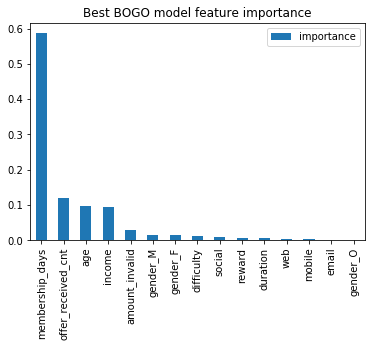

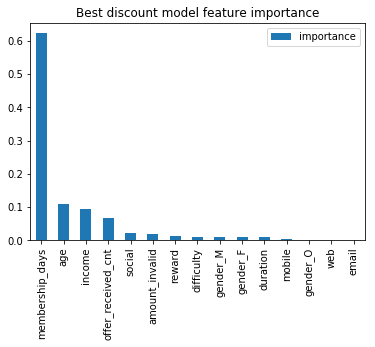

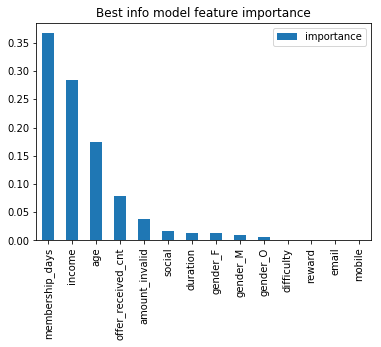

In [101]:
# display the feature importance
# BOGO model
drop_cols_prep=['person','offer_id','offer_responded','offer_type']
features,target=data_prep(bogo_offer,drop_cols_prep)

feature_importances = pd.DataFrame(bogo_2.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best BOGO model feature importance')
plt.show()

#discount model
feature_importances = pd.DataFrame(discount_2.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best discount model feature importance')
plt.show()

#informational model
drop_cols_prep=['person','offer_id','offer_responded','offer_type']
features,target=data_prep(informational_offer,drop_cols_prep)
#print feature importance
feature_importances = pd.DataFrame(info_2.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best info model feature importance')
plt.show()